In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 128#256#512

nTime = nLat
nSimTime = nLat*100#2048
lSim = 0
nSims = 20#00

phi0 = 1.
m2eff = 1.
lamb = 1.
lenLat = 1.;
phi_initial = 0
nCols = 2

nyq = nLat//2
spec = nyq

alpha = 8
step = 1
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha*step

### Theoretical Field PS 

In [4]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nT, nL, tem, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda gam, tem: '_for_temp{:.4f}'.format(tem)+'_gam{:.4f}'.format(gam)
classical_field = lambda gam, tem: np.asarray(np.reshape(np.genfromtxt('/gpfs/dpirvu/thermal_bubbles/phi4_gam{:.4f}'.format(gam)+'_t128_x128_temp{:.4f}'.format(tem)+'_fields.dat'), (nTime, nLat)))

smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, tem, gam, sim, sigma=0.):
    data = np.genfromtxt(sim_location((nSimTime if gam >= 0. else nTime), nL, tem, gam, sim))
    simulation = [np.reshape(data[:,col], (nT, nL)) if sigma == 0. else np.asarray([smoothen(slic, sigma) for slic in simulation[col]]) for col in range(nCols)]
    return np.asarray(simulation)[:, -nL:, :]

In [5]:
# field spectrum
# prediction from lattice renormalization

freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
omega = np.sqrt(freqs**2. + m2eff)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda tem: np.asarray([np.sqrt(1./(np.exp(omega[k]/tem) - 1.)) / np.sqrt(omega[k]) if k != nLat//2 else 0 for k in range(nLat)])
pspec = lambda tem, sigma: np.abs(spectral_field(tem) * Filter(sigma))**2.
sigma0sq_th = lambda tem, sigma: np.sum(pspec(tem, sigma))

V = lambda x, gam: (- 0.5 * m2eff * x**2. + lamb * x**4. / 24. - gam * x) if gam == 0.25 else (- 0.5 * m2eff * x**2. + lamb * x**4. / 24. - gam * x**3. / 6. if x < 0. else - 0.5 * m2eff * x**2. + lamb * x**4. / 24.) if gam == 0.5 else (- 0.5 * m2eff * x**2. + lamb * x**4. / 24.) if gam == 0. else (0.5 * m2eff * x**2. + lamb * x**4. / 24.)

th_masses = lambda gam, tem, sigma: (m2eff if gam == -1. else -m2eff) + 0.5 * lamb * sigma0sq_th(tem, sigma)
masses_from_data_ps = lambda gam, tem: (m2eff if gam == 0 else -m2eff) + 0.5 * lamb * np.mean(all_data[tem, gam, :, 0, 0]**2.)
masses_from_classical_data_ps = lambda gam, tem: (m2eff if gam == -1. else -m2eff) + 0.5 * lamb * np.mean(classical_field(gam, tem)[0]**2.)

In [6]:
#gamma = list_gamma[0]
#for temp in list_temp[::100]:
#    print('temp, gamma:', temp, gamma)
#    field = classical_field(gamma, temp)
#    field = np.asarray([np.roll(slice, nLat//2) for slice in field])
#    fftfield = np.abs(np.fft.fftshift(np.fft.fft2(field)))**2.
#    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#    im = ax[0].imshow(field, aspect='auto', interpolation='none', origin='lower')
#    clb = plt.colorbar(im, ax = ax[0])
#    im = ax[1].imshow(fftfield, aspect='auto', interpolation='none', origin='lower')
#    clb = plt.colorbar(im, ax = ax[1])
#    plt.suptitle('Temperature = '+str(temp))
#    plt.show()

#gamma = 0
#for temp in list_temp:
#    thpspec = pspec(temp, 0.)
#    thpspec[nLat//2] = 0.
#    fig, ax = plt.subplots(1, 1, figsize = (20,4))
#    plt.plot(freqs, thpspec, label='theoretical')
#    fld = classical_field(gamma, temp)[0]
#    plt.plot(freqs, np.abs(np.fft.fftshift(np.fft.fft(fld)))**2./nLat**2, 'o', ms=1, label='data')
#    plt.legend(); plt.show()

In [7]:
#dataPS = lambda sim, time: np.abs(np.fft.fftshift(np.fft.fft(all_data[tem][0][sim][0][time])))**2./nLat**2.
#for tem in range(len(list_temp)):
#    time = 0
#    fig, ax = plt.subplots(1, 1, figsize = (20,4))
#    plt.plot(freqs, pspec(list_temp[tem], 0.))
#    plt.plot(freqs, np.mean([dataPS(sim, time) for sim in range(nSims-lSim)], axis=0))
#    [plt.plot(freqs, dataPS(sim, time), 'o', ms=2) for sim in range(nSims-lSim)]
#    plt.show()

In [8]:
#xlist = np.linspace(-4, 4, 100)
#plt.figure()
#[plt.plot(xlist, [V(x, gam) for x in xlist], label=f'V($\phi; \gamma = $%5.2f)'%(gam)) for gam in [-1, 0, 0.25, 0.5]]
#plt.legend(); plt.show()

### Extract data from files

In [9]:
list_gamma = [-1., 0.]#[-1., 0., 0.25, 0.5]
list_temp = (10.**(np.arange(0, 7, 1)/2.)).tolist(); print(list_temp)#(10.**np.arange(0, 5)).tolist()[:1]
fine_temp_list = np.linspace(min(list_temp), max(list_temp), 100)
filter_size = 0.

[1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0]


In [10]:
all_data = np.asarray([[[extract_sim(nTime, nLat, temp, gamma, sim, filter_size) for sim in range(lSim, nSims)] for gamma in list_gamma] for temp in list_temp])

(7, 2, 20, 2, 128, 128)
plotting simulation 14


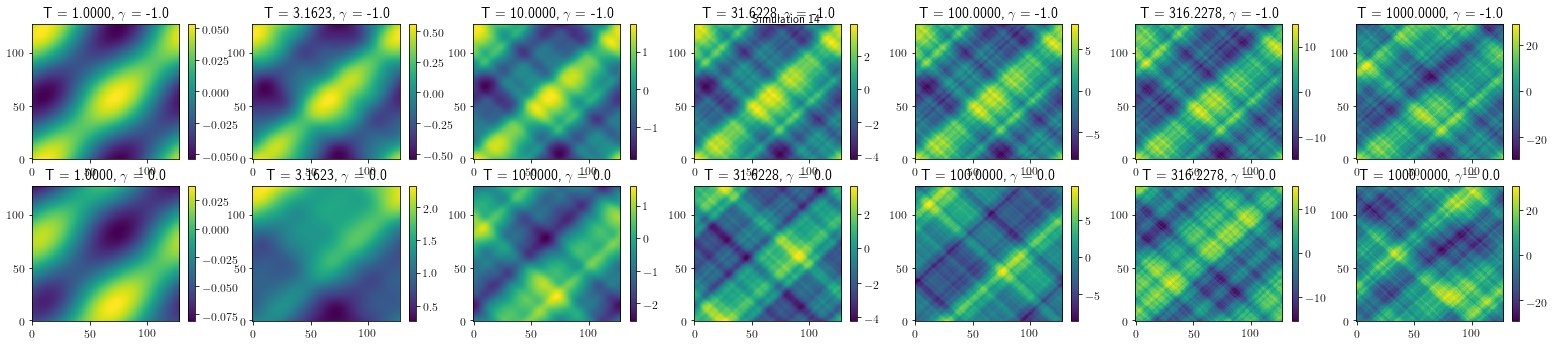

In [11]:
print(np.shape(all_data))
sim = random.randint(0, nSims-lSim-1); print('plotting simulation', sim)

fig, ax = plt.subplots(len(list_gamma), len(list_temp), figsize = (4*len(list_temp), 2.5*len(list_gamma)))
for gamma in range(len(list_gamma)):
    for temp in range(len(list_temp)):
        im0 = ax[gamma][temp].imshow(all_data[temp][gamma][sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[gamma][temp])
        ax[gamma][temp].set_title('T = {:.4f}'.format(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
plt.suptitle('Simulation '+str(sim))
plt.show()

In [12]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses(bool, multiplier, gam):
    PSPECS, masses = [[]]*all_data.shape[0], [[]]*all_data.shape[0]
    for temp in range(len(list_temp)):
        for sim in range(0, nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            simulation = simulation - np.mean(simulation)
            PSPECS[temp].append(np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2./nLat**2./nTime**2.)

        PSPECS[temp] = np.mean(PSPECS[temp], axis = 0)
        T, N = PSPECS[temp].shape
        oo = kk = freqs

        maxVal = np.mean(PSPECS[temp]) + multiplier * np.std(PSPECS[temp])
        osccoords = np.argwhere(PSPECS[temp] > maxVal)

        popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
        masses[temp] = popt[-1]

        if bool:
            lim = max(freqs)
            fig, ax = plt.subplots(1, 2, figsize = (10, 3.5))
            ax[0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
            ax[0].set_xlim(-lim,lim); ax[0].set_ylim(0,lim)
            ax[0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

            lim = 50
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', label=f'$m^2=$%5.5f'%popt[-1])
            im = ax[1].imshow(PSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            #ax[1].imshow(np.amax(PSPECS[temp])/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[1])
            ax[1].set_title('T = {:.4f}'.format(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[1].set_xlabel(r'$\bar{k}$'); ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].set_ylim(0,lim); ax[1].set_xlim(-lim,lim)
            ax[1].axvline(0, color='white', ls=':'); ax[1].axhline(0, color='white', ls=':')
            [i.legend() for i in ax]; plt.show()
    return masses

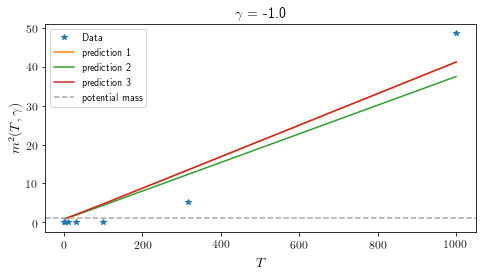

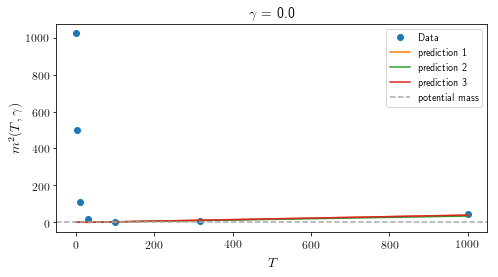

In [29]:
multiplier = 1

for gam in range(len(list_gamma)):
    masses = get_masses(False, multiplier, gam)

    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', label='Data')
    plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], tem, 0.)) for tem in fine_temp_list], label='prediction 1')
    plt.plot(list_temp, [np.abs(masses_from_data_ps(gam, tem)) for tem in range(len(list_temp))], label='prediction 2')
    plt.plot(list_temp, [np.abs(masses_from_classical_data_ps(list_gamma[gam], tem)) for tem in list_temp], label='prediction 3')

    plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
    plt.title(f'$\gamma$ = '+str(list_gamma[gam]))
    plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
    plt.legend(); plt.show()

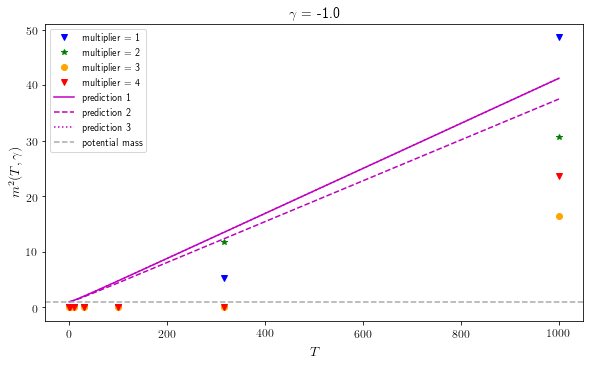

In [42]:
gam = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
for multiplier in range(1, 5):
    masses = get_masses(False, multiplier, gam)
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=next(colors), label='multiplier = '+str(multiplier))

col = next(colors)
lines = cycle(('-', '--', ':'))
plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], tem, 0.)) for tem in fine_temp_list], color=col, ls=next(lines), label='prediction 1')
plt.plot(list_temp, [np.abs(masses_from_data_ps(gam, tem)) for tem in range(len(list_temp))], color=col, ls=next(lines), label='prediction 2')
plt.plot(list_temp, [np.abs(masses_from_classical_data_ps(list_gamma[gam], tem)) for tem in list_temp], color=col, ls=next(lines), label='prediction 3')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title(f'$\gamma$ = '+str(list_gamma[gam]))
plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()

### Get profile of omega ^2

In [ ]:
wall_profile = np.mean(np.asarray(np.reshape(np.genfromtxt('/gpfs/dpirvu/thermal_bubbles/phi4_gam0.0000_t1024_x1024_fields.dat'), (nTime, nLat))), axis=0)
wall_PS = np.abs(np.fft.fftshift(np.fft.fft(wall_profile)))**2.
fig, ax = plt.subplots(1, 2, figsize = (25, 4))
ax[0].plot(np.arange(nLat)*dx, wall_profile, 'r')
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$\phi_x$')
ax[0].axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[0].axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[1].plot(freqs, wall_PS, 'r')
ax[1].set_xlabel(f'$k$')
ax[1].set_ylabel(f'$|\phi_k|^2$')

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


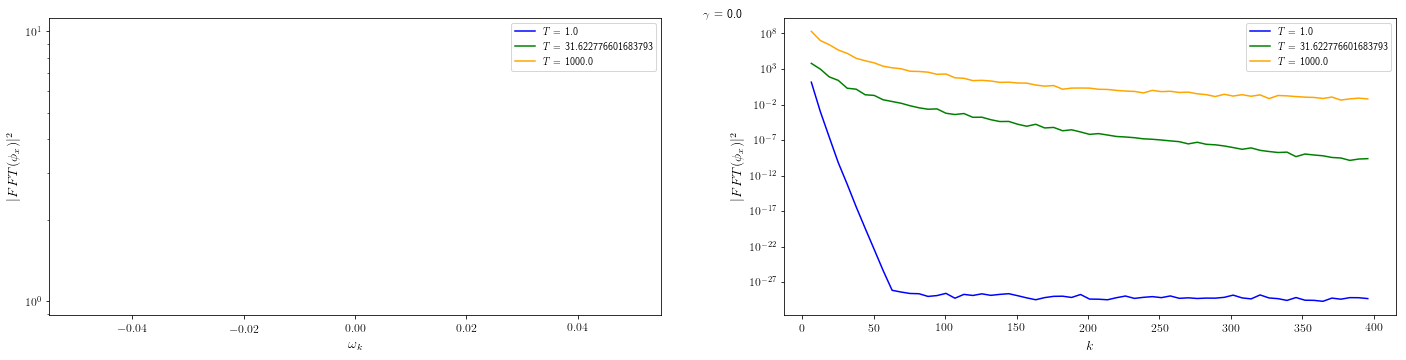

In [47]:
def get_pspec(gam, tem, thresh):
    pspecs, saves = [], []
    for sim in range(0, nSims-lSim):
        simulation = all_data[tem][gam][sim][0]
        T, N = simulation.shape
        simulation = simulation - np.mean(simulation)
        pspecs.append(np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2.)

    pspecs = np.mean(pspecs, axis = 0)
    T, N = pspecs.shape
    kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
    saves = pspecs[oo==0., kk>0]
    pspecs = pspecs[:, (kk>0)&(kk<thresh)]
#    print(kk[(kk>0)&(kk<thresh)])
    return np.mean(pspecs, axis=1), saves, kk


thresh = 0.5;
gam = 1

colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
fig, ax = plt.subplots(1, 2, figsize = (25, 5))
for tem in range(0, len(list_temp), 3):
    av_PS, saves, kk = get_pspec(gam, tem, thresh)   
    col = next(colors)
    
    ax[0].plot(freqs[(kk>0)&(kk<5)], av_PS[(kk>0)&(kk<5)], label=f'$T$ = '+str(list_temp[tem]), color=col)
    ax[1].plot(freqs[freqs>0], saves, label=f'$T$ = '+str(list_temp[tem]), color=col)

#ax[0].plot(freqs[(kk>0)&(kk<5)], np.asarray(wall_PS)[(kk>0)&(kk<5)], label='Wall')
#ax[1].plot(freqs[freqs>0], np.asarray(wall_PS)[(kk>0)], label='Wall')
ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(f'$\omega_k$')
ax[1].set_xlabel(f'$k$')
[i.set_ylabel(f'$|FFT(\phi_x)|^2$') for i in ax]
[i.legend() for i in ax]
plt.suptitle(f'$\gamma$ = '+str(list_gamma[gam]))
plt.show()

### Separate Real and Imaginary Contributions to PS

In [50]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses_seps(bool, multiplier, gam):
    rePSPECS, imPSPECS, remasses, immasses = [[]]*all_data.shape[0], [[]]*all_data.shape[0], [[]]*all_data.shape[0], [[]]*all_data.shape[0]
    for temp in range(len(list_temp)):
        for sim in range(0, nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            simulation = simulation - np.mean(simulation)
            fftfield = np.fft.fftshift(np.fft.fft2(simulation))
            rePSPECS[temp].append(np.abs(fftfield.real)**2.)
            imPSPECS[temp].append(np.abs(fftfield.imag)**2.)

        rePSPECS[temp], imPSPECS[temp] = np.mean(rePSPECS[temp], axis = 0), np.mean(imPSPECS[temp], axis = 0)
        oo, kk = freqs, freqs

        remaxVal, immaxVal = np.mean(rePSPECS[temp]) + multiplier * np.std(rePSPECS[temp]), np.mean(imPSPECS[temp]) + multiplier * np.std(imPSPECS[temp])
        reosccoords, imosccoords = np.argwhere(rePSPECS[temp] > remaxVal), np.argwhere(imPSPECS[temp] > immaxVal)

        remasses[temp], _ = sco.curve_fit(omega_fit, kk[reosccoords[:,1]], oo[reosccoords[:,0]]**2.)
        immasses[temp], _ = sco.curve_fit(omega_fit, kk[imosccoords[:,1]], oo[imosccoords[:,0]]**2.)

        if bool:
            lim = max(freqs)
            fig, ax = plt.subplots(1, 4, figsize = (22, 4))
            ax[0].plot(kk[reosccoords[:,1]], oo[reosccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*remasses[temp])), label=f'$m^2=$%5.5f'%remasses[temp])
            ax[0].set_xlim(-lim,lim); ax[0].set_ylim(0,lim)
            ax[0].set_title('Real T = {:.4f}'.format(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[0].axhline(remasses[temp], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

            ax[2].plot(kk[imosccoords[:,1]], oo[imosccoords[:,0]], 'o', ms=5, label='freqs')
            ax[2].plot(kk, np.sqrt(omega_fit(kk,*immasses[temp])), label=f'$m^2=$%5.5f'%immasses[temp])
            ax[2].set_xlim(-lim,lim); ax[2].set_ylim(0,lim)
            ax[2].set_title('Imaginary T = {:.4f}'.format(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[2].axhline(immasses[temp], color='darkgray', ls=':', label='best fit')
            ax[2].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

            lim = 50
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*remasses[temp])), color = 'y', label=f'$m^2=$%5.5f'%remasses[temp])
            im = ax[1].imshow(rePSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            #ax[1].imshow(np.amax(rePSPECS[temp])/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[1])
            ax[1].set_title('Real T = {:.4f}'.format(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[1].set_xlabel(r'$\bar{k}$'); ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].set_xlim(-lim,lim); ax[1].set_ylim(0,lim)
            ax[1].axvline(0, color='white', ls=':'); ax[1].axhline(0, color='white', ls=':')
            
            ax[3].plot(kk, np.sqrt(omega_fit(kk,*immasses[temp])), color = 'y', label=f'$m^2=$%5.5f'%immasses[temp])
            im = ax[3].imshow(imPSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            #ax[3].imshow(np.amax(imPSPECS[temp])/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[3])
            ax[3].set_title('Imaginary T = {:.4f}'.format(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[3].set_xlabel(r'$\bar{k}$'); ax[3].set_ylabel(r'$\bar{\omega_k}$')
            ax[3].set_xlim(-lim,lim); ax[3].set_ylim(0,lim)
            ax[3].axvline(0, color='white', ls=':'); ax[3].axhline(0, color='white', ls=':')
            [i.legend() for i in ax]; plt.show()
    return remasses, immasses

$\gamma = $ -1.0


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt


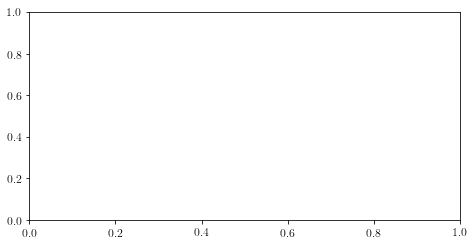

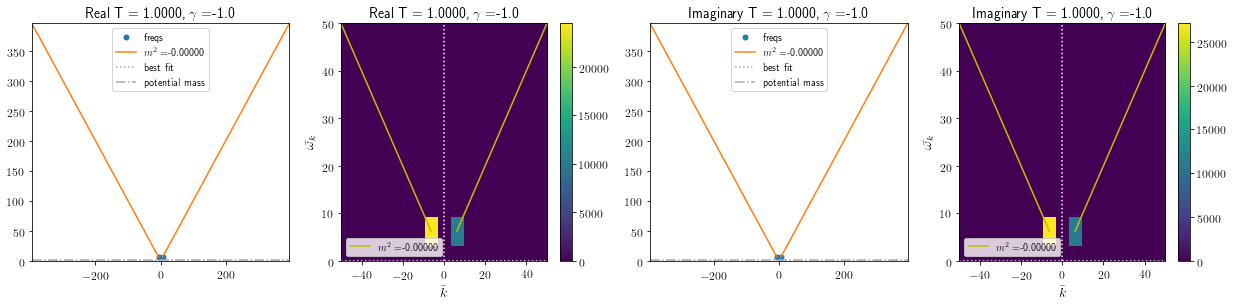

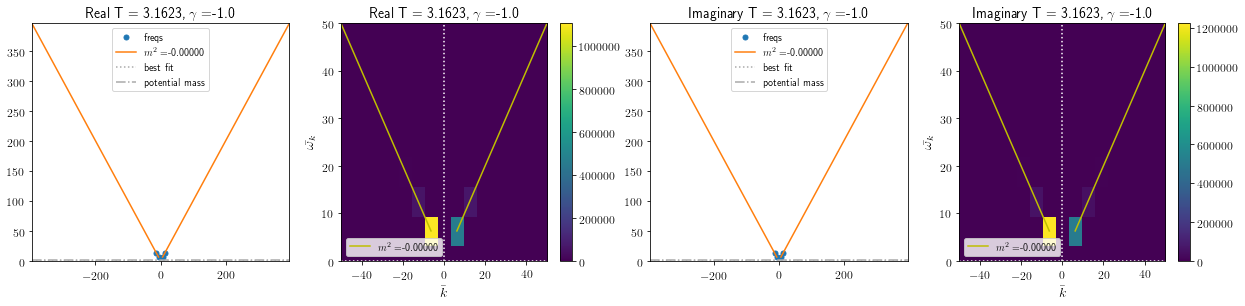

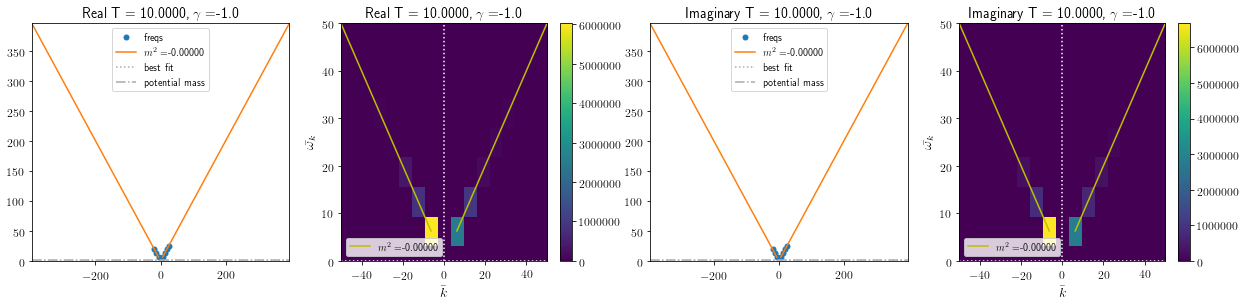

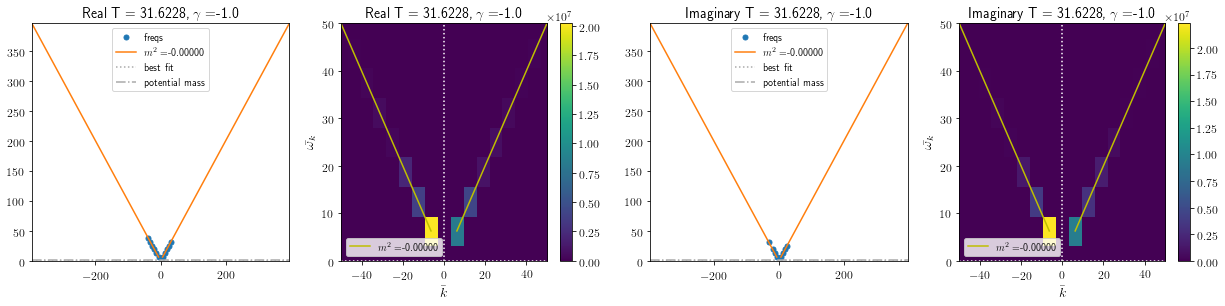

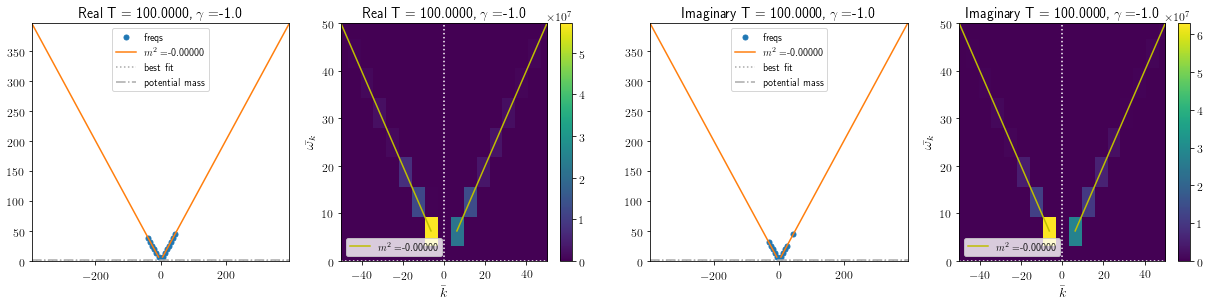

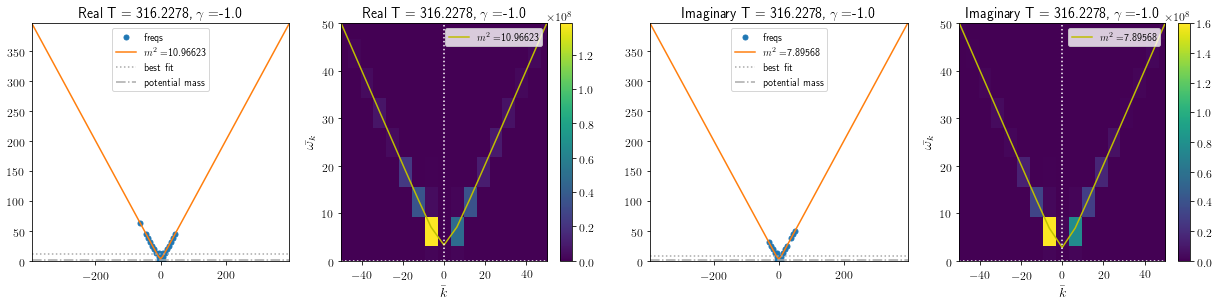

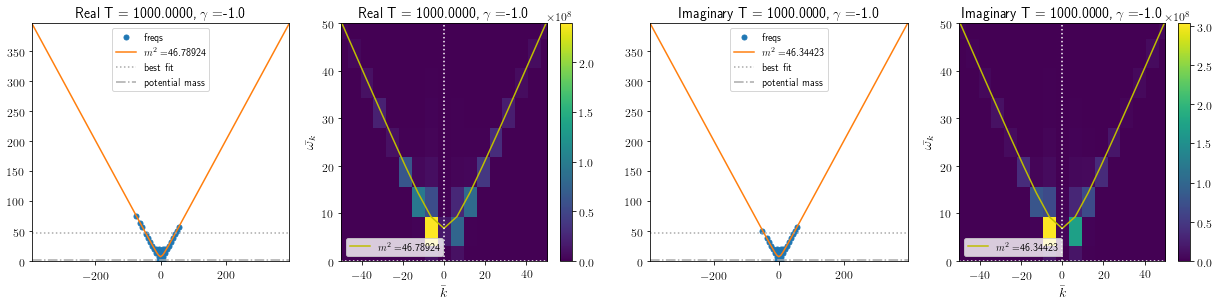

$\gamma = $ 0.0


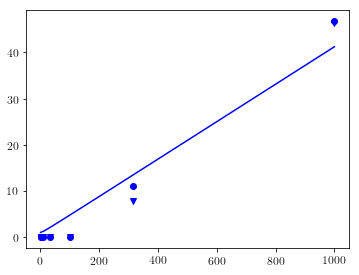

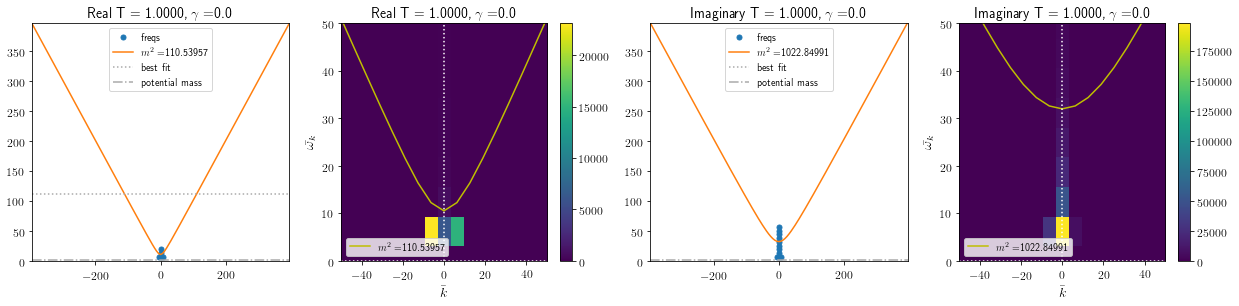

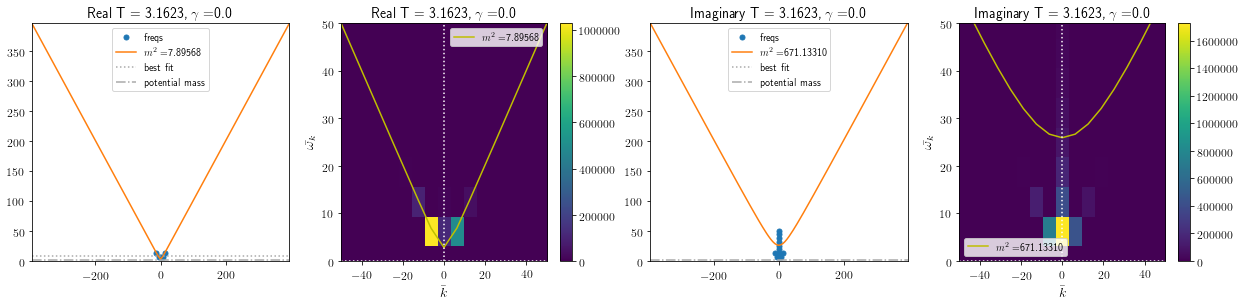

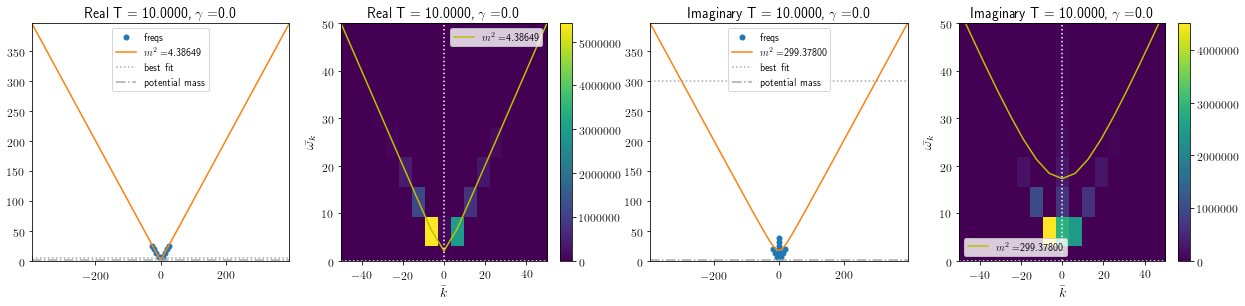

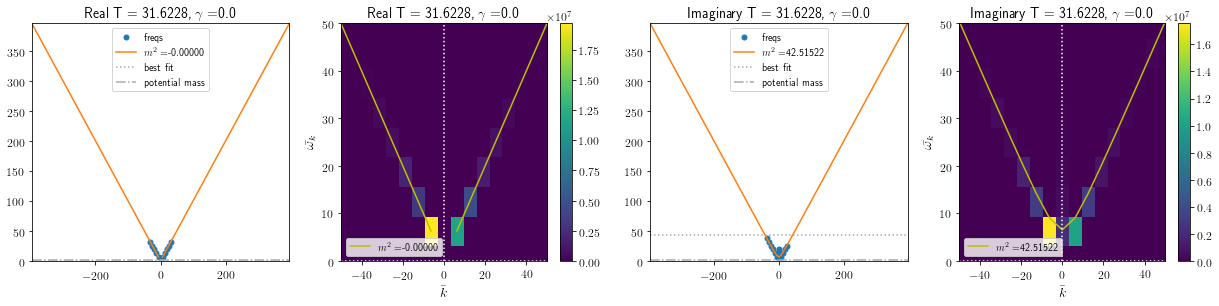

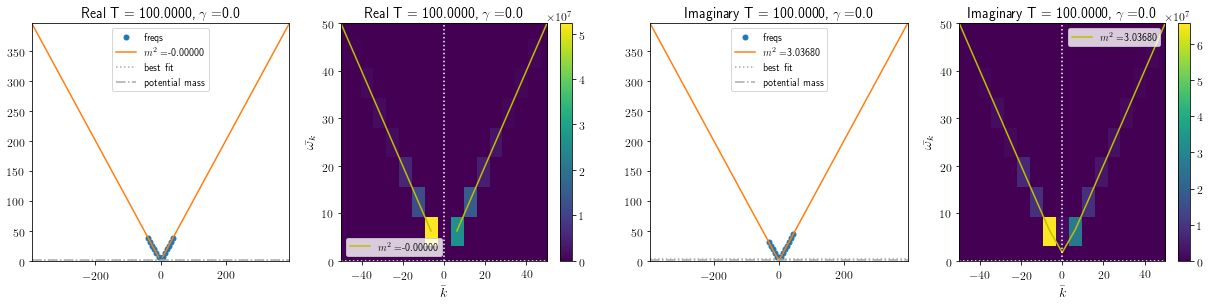

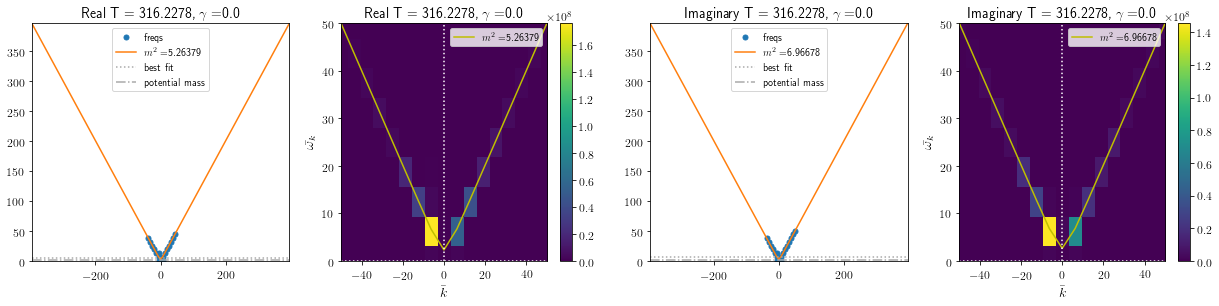

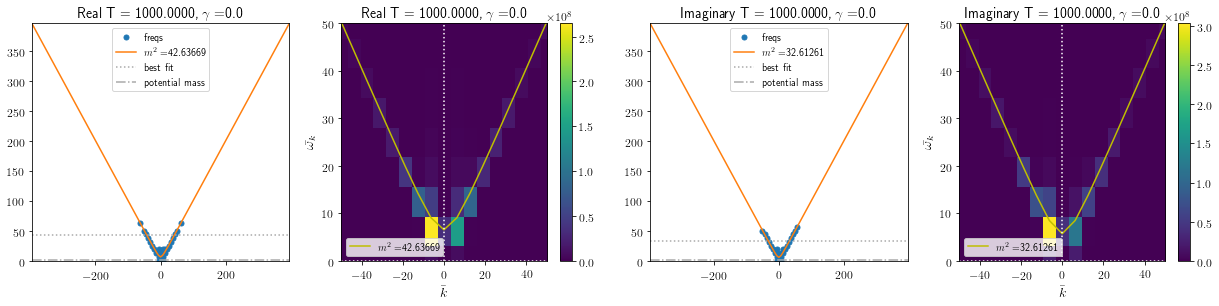

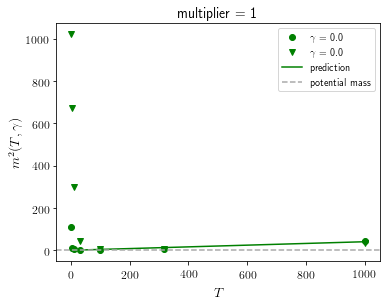

In [51]:
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v'))

multiplier = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
for gam in range(len(list_gamma[:])):
    print(f'$\gamma = $', list_gamma[gam])
    col = next(colors)
    remasses, immasses = get_masses_seps(True, multiplier, gam)
    plt.plot(list_temp, remasses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma[gam]))
    plt.plot(list_temp, immasses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma[gam]))
    plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], tem, 0.)) for tem in fine_temp_list], color=col, label='prediction')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title('multiplier = '+str(multiplier))
plt.ylabel(f'$m^2(T, \gamma)$')
plt.xlabel(f'$T$')
plt.legend()
plt.show()